In [0]:
!pip install pyarabic

In [0]:
import sys
import importlib
import numpy as np 
import json, os, glob, re
from nltk import word_tokenize
import matplotlib.pyplot as plt
from matplotlib import ticker

In [0]:
! rm -R /content/Hadith-Segmentation-Using-Ngrams/
!git clone https://github.com/AhmadM-DL/Hadith-Segmentation-Using-Ngrams.git

In [0]:
sys.path.append('/content/Hadith-Segmentation-Using-Ngrams/')

In [0]:
import hadith_ngram_lists_validator as validator
import sanad_maten_ngrams_extractor as extractor
import sunnah_com_books_extractor as book_extractor

importlib.reload(book_extractor)
importlib.reload(extractor)
importlib.reload(validator)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#### Scraped Books Info

In [0]:
books_paths = ["/content/drive/My Drive/Colab Notebooks/NLP/Books/Jami` at-Tirmidhi.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Sahih Muslim.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Sahih al-Bukhari.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Sunan Abi Dawud.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Sunan an-Nasa'i.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Riyad as-Salihin.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Sunan Ibn Majah.json",
               "/content/drive/My Drive/Colab Notebooks/NLP/Books/Muwatta Malik.json",]

In [0]:
output_path = "/content/drive/My Drive/Colab Notebooks/NLP/Books/"
output = {}
for book_path in books_paths:
  book = json.load( open(book_path,"r") )
  sanad, maten, atraf = book_extractor.book_maten_sanad_atraf_extractor(book)
  
  sanad = sanad.split("\n")[:-1]
  maten = maten.split("\n")[:-1]
  atraf = atraf.split("\n")[:-1]

  assert len(sanad)==len(maten)
  assert len(sanad)==len(atraf)
  output[book["Title"]] = {}

  output[book["Title"]]["#_hadith_extracted"] = len(sanad)

  indices_empty_sanad = [i for i, s in enumerate(sanad) if s == '']
  sanad = [s for i, s in enumerate(sanad) if not i in indices_empty_sanad]
  maten = [m for i, m in enumerate(maten) if not i in indices_empty_sanad]
  
  output[book["Title"]]["#_hadith_with_sanad"] = len(sanad)

  sanad_hadith_lengths = [len(word_tokenize(s)) for s in sanad]
  maten_hadith_lengths = [len(word_tokenize(m)) for m in maten]

  output[book["Title"]]["sanads_info"]={}
  output[book["Title"]]["sanads_info"]["min_length"] = int(np.min(sanad_hadith_lengths))
  output[book["Title"]]["sanads_info"]["max_length"] = int(np.max(sanad_hadith_lengths))
  output[book["Title"]]["sanads_info"]["avg_length"] = int(np.average(sanad_hadith_lengths))

  output[book["Title"]]["matens_info"]={}
  output[book["Title"]]["matens_info"]["min_length"] = int(np.min(maten_hadith_lengths))
  output[book["Title"]]["matens_info"]["max_length"] = int(np.max(maten_hadith_lengths))
  output[book["Title"]]["matens_info"]["avg_length"] = int(np.average(maten_hadith_lengths))

json.dump(output, open(output_path+"books_info.json","w"))

#### View TF% vs KTACC

In [0]:
ex_res={}

ex_root_dir = "/content/drive/My Drive/Colab Notebooks/NLP"

files = [f for f in glob.glob(ex_root_dir+'/*') if os.path.isdir(f)]
ex_dir_regex = re.compile("ex\d+")
for f in files:
  fname = os.path.split(f)[1]
  if(ex_dir_regex.match(fname)): 
    
    ex_number = int(re.findall(r'\d+', fname)[0])
    if ex_number>13: continue
    
    top_frequent_percent = json.load(open(f+"/cfg.json","r"))["top_frequent_percent"]
    bl_accuracies = json.load(open(f+"/lists_validation_output_0.json","r"))["Accuracies"]
    ig_accuracies = json.load(open(f+"/lists_validation_output_1.json","r"))["Accuracies"]
    ex_res[ex_number] = {"top_frequent_percent":top_frequent_percent,
                         "bl_acc":bl_accuracies,
                         "ig_acc":ig_accuracies}

In [0]:
tfp = []

bl_acc={0:[], 1:[],
        2:[], 3:[],
        4:[], 5:[]}

ig_acc={0:[], 1:[],
        2:[], 3:[],
        4:[], 5:[]}

for i in range(1,13+1):

  tfp.append( float(ex_res[i]["top_frequent_percent"]) )

  bl_acc[0].append( float(ex_res[i]["bl_acc"]["0"]) )
  bl_acc[1].append( float(ex_res[i]["bl_acc"]["1"]) )
  bl_acc[2].append( float(ex_res[i]["bl_acc"]["2"]) )
  bl_acc[3].append( float(ex_res[i]["bl_acc"]["3"]) )
  bl_acc[4].append( float(ex_res[i]["bl_acc"]["4"]) )
  bl_acc[5].append( float(ex_res[i]["bl_acc"]["5"]) )

  ig_acc[0].append( float(ex_res[i]["ig_acc"]["0"]) )
  ig_acc[1].append( float(ex_res[i]["ig_acc"]["1"]) )
  ig_acc[2].append( float(ex_res[i]["ig_acc"]["2"]) )
  ig_acc[3].append( float(ex_res[i]["ig_acc"]["3"]) )
  ig_acc[4].append( float(ex_res[i]["ig_acc"]["4"]) )
  ig_acc[5].append( float(ex_res[i]["ig_acc"]["5"]) )

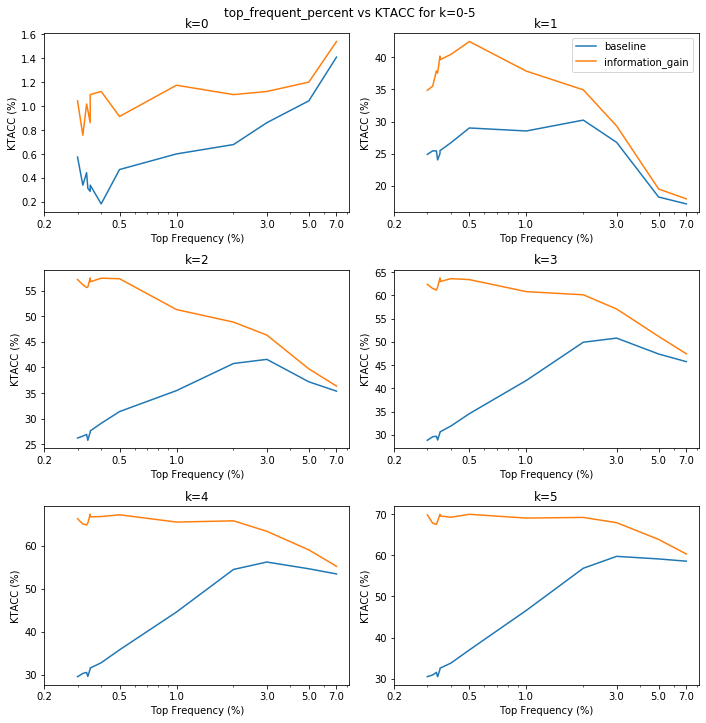

In [0]:
tfp_sorted_indices = list(np.argsort(tfp))

fig = plt.figure(figsize=(10,10))
plt.suptitle("top_frequent_percent vs KTACC for k=0-5",y=1)
for k in range(0,6):
  ax = plt.subplot(3,2,k+1)
  plt.plot([tfp[i] for i in tfp_sorted_indices],[bl_acc[k][i] for i in tfp_sorted_indices])
  plt.plot([tfp[i] for i in tfp_sorted_indices],[ig_acc[k][i] for i in tfp_sorted_indices])
  ax.set_xscale('log')
  ax.set_xticks([0.2, 0.5, 1, 3, 5, 7])
  ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
  plt.xlabel("Top Frequency (%)")
  plt.ylabel("KTACC (%)")
  plt.title("k=%d"%k)
fig.legend(['baseline', 'information_gain'], loc=(0.81,0.9))
fig.tight_layout()
